<a href="https://colab.research.google.com/github/Charles-Scott-Green/Argument-mining/blob/master/Argument_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Argument Mining - Context Dependent Claims


<strong>"I have heard you  hold the world record in debate competition wins agains humans, but I suspect you have never debated a machine.  Welcome to the future."           --IBM Project Debater (aka Miss Debater)</strong>

While Natural Language Processing has been widely studied over several years, IBM Watson's Project Debater demonstrated a big step in the realm of Artificial Intelligence.  The potential applications of such a project are vast.  Even elements of this project have very useful implementations that, while not obvious, are worth consideration.

Many different elements went into IBM's robust project, but Argument Mining is of particular interest.  This project is an attempt to design and implement an Argument Mining work flow.


## Downloads

In [0]:
!python -m spacy download en_core_web_lg --quiet

     |████████████████████████████████| 826.9MB 62.8MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.8MB/s 


In [0]:
!pip install spacy-wordnet

     |████████████████████████████████| 655kB 5.0MB/s 
     |████████████████████████████████| 1.4MB 33.5MB/s 
  Created wheel for spacy-wordnet: filename=spacy_wordnet-0.0.4-py2.py3-none-any.whl size=650292 sha256=be6a35c1c91a4d5b82b832f04c33ce21c750725aeea429f69e1b592f55fc5d8c
  Stored in directory: /root/.cache/pip/wheels/25/93/1d/c86db913cd146fc9ddb26d10f56579c5d58a3e00bc8f96a3a6
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394472 sha256=a14940cc76e879e2a1dbe83921cfbd991be203a519047b19906a3b9ec070093d
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built spacy-wordnet nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


## Import Libraries and initialize settings

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [0]:
import re
import string
import math
from tqdm import tqdm

In [0]:
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize, word_tokenize
from pprint import pprint
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer

In [0]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [0]:
import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
from spacy.lang.en.stop_words import STOP_WORDS
from spacy_wordnet.wordnet_annotator import WordnetAnnotator

nlp = spacy.load("en_core_web_lg")
nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')

In [0]:
import warnings
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
warnings.filterwarnings('ignore')

In [0]:
from sklearn.model_selection import train_test_split as tts 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

from imblearn.over_sampling import SMOTE

In [0]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pickle

## Define Functions

In [0]:
def get_target_data(path):
    df = pd.read_csv(path)
    df['cdc_present'] = (df['cdc'] != '---').astype(int)

    return df['cdc_present']

In [0]:
def topic_domains(topic):
    raw_domains = []
    common_domains = []

    for chunk in nlp(topic).noun_chunks:
        rt_nn = chunk.root
        raw_domains.append(rt_nn._.wordnet.wordnet_domains())

    if len(raw_domains) > 0:
        reference = raw_domains[0]
    else:
        return list(raw_domains)
        
    for domain in raw_domains:
        common_domains = set(reference) & set(domain)
        
    return list(common_domains)

In [0]:
def expanded_sentence_similarity(topic, sentence):
    
    extended_topic = []
    domains = topic_domains(topic)
    
    if len(domains) < 1:
        return nlp(topic).similarity(nlp(sentence))
    else:
        for token in nlp(topic):
            synsets = token._.wordnet.wordnet_synsets_for_domain(domains)
            if synsets: 
                lfs = []
                for syn in synsets:
                    lfs.extend(syn.lemma_names())
                    extended_topic.append('({})'.format('|'.join(set(lfs))))
            else:
                extended_topic.append(token.text)

        tokenized_extended_topic = nlp(' '.join(extended_topic))

    return tokenized_extended_topic.similarity(nlp(sentence))            

In [0]:
def subject_match(topic, sentence):
    
    ntopic = nlp(topic)
    scores = []
    for chunk in nlp(sentence).noun_chunks:
        scores.append(chunk.similarity(ntopic))
    
    return np.mean(scores)

In [0]:
def subject_match2(topic, sentence):
    
    ntopic = nlp(topic)
    scores = []
    for chnk in nlp(sentence).noun_chunks:
        for tchnk in ntopic.noun_chunks:
            scores.append(chnk.similarity(tchnk))
    
    return np.mean(scores)

In [0]:
def includes_that(sentence):
    check = []
    for tok in sentence:
        if tok.tag_ == 'IN':
            check.append(tok.text)
    if 'that' in check:
        return 1
    else:
        return 0

In [0]:
def patterns(sentence, pattern_type='dep'):
    
    pat = []
    if pattern_type == 'dep':
        pat = [tok.dep_ for tok in sentence]
    elif pattern_type == 'tag':
        pat = [tok.tag_ for tok in sentence]
    
    return '|'.join(pat)

In [0]:
def pos_pattern(sentence):
    pat = []
    for tok in sentence:
        pat.append(tok.pos_)

    return '|'.join(pat)


In [0]:
def pattern_in_text(pattern, sentence):
    text_pattern = pos_pattern(sentence)

    if pattern in text_pattern:
        return 1
    else:
        return 0

In [0]:
def infinitive_verb_present(sentence):
    text_pattern = pos_pattern(sentence)
    infinitive_pattern = 'PART|VERB'

    if infinitive_pattern in text_pattern:
        return 1
    else:
        return 0


In [0]:
def sentiment_subjectivity(sentence, score_type='sentiment'):
    analyzer = SentimentIntensityAnalyzer()

    if score_type == 'sentiment':
        pos = analyzer.polarity_scores(sentence)['pos']
        neg = analyzer.polarity_scores(sentence)['neg']
        return pos/neg
    
    else:
        return analyzer.polarity_scores(sentence)['compound']

In [0]:
def is_sentence(clause):
    nn = 2
    vb = 1
    cls = nlp(clause)
    for tok in cls:
        if tok.pos_ in ['NOUN', 'PROPN', 'PRON']:
            nn -= 1
        elif tok.pos_ in ['VERB']:
            vb -= 1
    if nn < 1 and vb < 1:
        return True
    else:
        return False

In [0]:
def get_clauses(sentence):
    """Sentence type is a string."""
    subtree_phrases = []
    
    for tok in nlp(sentence):
        if tok.head.pos_ == 'VERB':
            if len([tok for tok in tok.subtree]) >= 3:
                subtree_prhase = ''.join(tok.text_with_ws for tok in tok.subtree)
                if subtree_prhase != sentence:
                    if is_sentence(subtree_prhase):
                        splits = subtree_prhase.split(',')
                        if len(splits) == 1:
                            subtree_phrases.append(subtree_prhase)
                        else:
                            for split in splits:
                                if is_sentence(split):
                                    if split not in subtree_phrases:
                                        subtree_phrases.append(split) 
    
    raw_clauses = []
    clauses = []

    for phrase in subtree_phrases:
        tok_phrase = nlp(phrase)
        for chunk in tok_phrase.noun_chunks:
            span = tok_phrase[chunk.root.head.left_edge.i:chunk.root.head.right_edge.i+1]
            if span[0].pos_ in ['DET', 'ADP']:
                if span[1:].text not in raw_clauses:
                    if is_sentence(span[1:].text):
                        raw_clauses.append(span[1:].text)
            elif span.text not in raw_clauses:
                if is_sentence(span.text):
                    raw_clauses.append(span.text)
    
    if len(raw_clauses) == 0:
        clauses.append(sentence)
    else:
        for clause in raw_clauses:
            dup_checks = [(clause in check_clause) for check_clause in raw_clauses]
            if sum(dup_checks) == 1:
                clauses.append(clause)
                
    return clauses

In [0]:
def conf_matrix(y_true, y_predict):
    
    from sklearn.metrics import confusion_matrix
    
    data = confusion_matrix(y_true, y_predict)
    index = ['Actual_0', 'Actual_1']
    columns = ['Predicted_0', 'Predicted_1']
    
    return pd.DataFrame(data, index, columns)

In [0]:
def get_target_data(path):
    df = pd.read_csv(path)
    df['cdc_present'] = (df['cdc'] != '---').astype(int)

    return df['cdc_present']

In [0]:
def count_sentiment_words(sentence):
    analyzer = SentimentIntensityAnalyzer()
    wd_cnt = 0

    for tok in nlp(sentence):
        if analyzer.polarity_scores(tok.text)['compound'] != 0:
            wd_cnt += 1

    return wd_cnt

In [0]:
def count_syllables(sentence):
    """Given a string, calculates and returns the number of syllables of the word."""
    import string
    
    word_list = sentence.translate(string.punctuation).split()
    vowels = "aeiouy"
    tally = 0
    
    for word in word_list:
        word = word.lower()
        vowels = "aeiouy"
        count = 0
        
        if word[0] in vowels:
            count += 1

        for i in range(1, len(word)):
            if word[i] in vowels and word[i - 1] not in vowels:
                count += 1

        if word.endswith('e'):
            count -= 1

        if count == 0:
            count += 1
    
        tally += count
    
    return tally

In [0]:
def punct_marks(sentence):
    """Given a sentence, returns count and/or list of punctiation marks"""
    
    pm = []
    
    for tok in nlp(sentence):
        if tok.pos_ == 'PUNCT':
            pm.append(tok)
    return len(pm)

In [0]:
def noun_counts(sentence):
    
    chnk = []
    
    for chunk in nlp(sentence).noun_chunks:
        chnk.append(chunk)

    return len(chnk)

In [0]:
def word_count(sentence):
    wds = []
    for tok in nlp(sentence):
        if tok.pos_ != 'PUNCT':
            wds.append(tok)
    return len(wds)

In [0]:
def phrase_chunks(sentence):
    s = []
    for tok in nlp(sentence):
        if len([tok for tok in tok.subtree]) >=3:
            if ''.join(tok.text_with_ws for tok in tok.subtree) != str(sentence):
                s.append(''.join(tok.text_with_ws for tok in tok.subtree))
    return len(s)

In [0]:
def trim_dataframe(df):
    cls = [2,3,4,5,6]
    grm = [7,8,9,10,11]
    stn = [12,13,14,15,16]
    cols = ['cdc_present', 'context', 
            'clause', 'stance']
    
    ndf = df.copy()
    stances = []
    clauses = []

    for x in df.index:
        gr_chk = list(df.iloc[x,grm])
        gd_gram = np.nonzero(gr_chk)

        if len(gd_gram[0]) == 0:
            clauses.append('---') 
            stances.append(0)
        else:
            scores = list(abs(df.iloc[x, stn]))
            hi_scr = max(abs(df.iloc[x,stn]))
            sc_idx = scores.index(hi_scr)
            if sc_idx in gd_gram[0]:
                clauses.append(df.iloc[x,cls[sc_idx]])
                stances.append(df.iloc[x,stn[sc_idx]])
            else:
                idx = gd_gram[0][0]
                clauses.append(nxt_stp.iloc[i,cls[idx]])
                stances.append(nxt_stp.iloc[i,stn[idx]])
                

    ndf['clause'] = clauses
    ndf['stance'] = stances
    ndf = ndf.loc[ndf['clause'] != '---']
    ndf = ndf[cols]
    ndf.reset_index(drop=True, inplace=True)

    return ndf

## Define the Problem

The purpose of this project is to provide a proof of concept. 

<strong>Concept:</strong>

* <strong>Background -</strong> 
 * This project is designed with a competitive debater in mind.  
 * Competitive debate occurs at multiple levels of education.  With the need to balance school work and conducting research for case construction, debaters and coaches often seek research resources in the form of topic handbooks and topic briefs.  These resources are intended to supplement a debater's research.  
 * A tool that is able to parse articles, extract relevant context claims and, potentially, supporting evidence, would provide value to highly competitive programs and upstart programs trying to focus on learning the skill.
 * The value of this tool also extends beyond competitive debate to other competitive speech events.  Furthermore, it could develop into a powerful research tool that may collect information for school and scientific research, gathering contextual documentation of legal precedent. 

* <strong>Scope -</strong>
 * This project is a first step proof of concept.  Successfully producing a model that will be able to extract Context Dependent claims may aid to establish the workflow necessary for the model to evolve into argument/evidence mining.
 * This project will be focusing on mining arguments.  Specifically, context dependent claims.

* <strong>Context Dependent Claim -</strong>
 * A context dependent claim is a factual statement that directly affirms/negates a topic.  
  * Debaters will have a topic to begin.  This establishes one of the inputs for the model.  It provides both domain and context.
  * A context dependent claim can be either a sentence, or an independent clause within a sentence.

* <strong>Approach -</strong>
 * The approach will be based on a sentence by sentence basis.  That said, the process will be similar to a funnel.  
   * A number of articles will be collected.
   * Articles will be parsed into sentences.
   * Sentences will be modeled to find "candidates" that may contain CDC's.
   * Complex Candidate sentences will be parsed into clauses. Simple candidate sentences will be retained.
   * Clauses will be evaluated to determine if they are independent.
     * they must possess the minimum requirements of a simple sentence
     * Grammar will be evaluated 
     * Clauses determined to be considered as simple sentences will be retained; others discarded.
 * A model will be applied to clauses to establish the presence of a CDC.
 * Models have been trained and a training set has been held back to be used in this workflow.

## Load Data

Prior to this step, data underwent extensive cleaning and organization.  Due to computational limits, separate notebooks were used to perform specific tasks.  Below are links to notbooks.

1. Compiling and Cleaning Data
https://colab.research.google.com/drive/1h5Il3Q-VUhJZGqiiX72PKxQiFMGiw20q

2. Additional Cleaning and Feature Engineering
https://colab.research.google.com/drive/1il9K4mqyysOz--Dtl7n_6gjA7qbomfSY

3. Model Selection and Tuning.
https://colab.research.google.com/drive/1D-MEwYCTyzvGKPMCt-246rIcb3aVMIch

4. Extracting Clauses from Candidate Sentences for additional modeling.
https://colab.research.google.com/drive/1m__-m1W8HFNKO2xGq_ypMey7IXdqRU9E

5. Model Selection for classifying Clauses


In [0]:
# paths to data
path1 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 34 - Final Capstone/data/CDC Detection/cleaned.csv'
path2 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 34 - Final Capstone/data/CDC Detection/m1_test_set.csv'
path3 = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 34 - Final Capstone/data/CDC Detection/m2_test_set.csv'

# Data loaded is the training set that has been held back.
df = pd.read_csv(path1)
test_data_1 = pd.read_csv(path2)
test_data_2 = pd.read_csv(path3)

In [0]:
# Cleaned data ready for modeling
df.shape, test_data_1.shape, test_data_2.shape

((41999, 21), (10500, 611), (2171, 614))

In [0]:
# Get data to demonstrate 
df2 = pd.read_csv(path1)

In [0]:
df.head()

,Unnamed: 0,Unnamed: 0.1,text,topic,article,cdc,cdc_present,context,text_words,text_syllables,text_sentiment_words,text_punctuation,text_nouns,text_phrases,sent_rat,clauses,num_clauses,claused_sentence,context_similarity,expanded_similarity,subjectivity_score
0,0,0,Deficit spending is the amount by which a gove...,Europe should weaken its austerity measures to...,Deficit spending,---,False,austerity measures,35,67,3,10,10,12,0.085714,"["" or individual's spending exceeds income ove...",1,or individual's spending exceeds income over ...,0.326836,0.259504,0.0000
1,1,1,Government deficit spending is a central point...,Europe should weaken its austerity measures to...,Deficit spending,---,False,austerity measures,14,29,1,2,4,5,0.071429,['Government deficit spending is a central poi...,1,Government deficit spending is a central point...,0.373849,0.267986,-0.4019
2,2,2,Government deficit spending is a central point...,Europe should weaken its austerity measures to...,Deficit spending,---,False,austerity measures,17,37,2,2,6,6,0.117647,['prominent economists holding differing views'],1,prominent economists holding differing views,0.267243,0.106333,0.3182
3,3,3,The mainstream economics position is that defi...,Europe should weaken its austerity measures to...,Deficit spending,---,False,austerity measures,66,122,7,7,15,22,0.106061,['deficit spending is desirable and necessary ...,4,deficit spending is desirable and necessary as...,0.461772,0.240641,-0.9280
4,4,4,"This is derived from Keynesian economics, and ...",Europe should weaken its austerity measures to...,Deficit spending,---,False,austerity measures,34,64,3,5,6,11,0.088235,['has been the mainstream economics view (in t...,1,has been the mainstream economics view (in the...,0.318571,0.306673,0.3612


Test data contains over 10 thousand sentences.  The task is to extract the context dependent claims from the sentences.

## Explore data

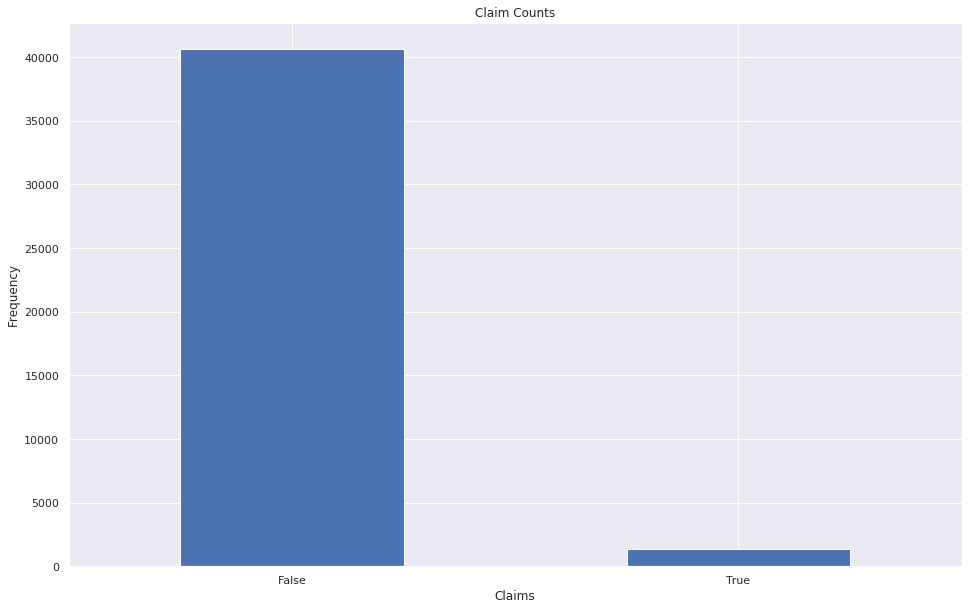

In [0]:
# Explore target data
count_claims = pd.value_counts(df['cdc_present'], sort=True)

plt.figure(figsize=(16,10))
count_claims.plot(kind='bar', rot=0)

plt.title('Claim Counts')
plt.xticks(range(2))
plt.xlabel('Claims')
plt.ylabel('Frequency')

plt.show()

The first filter of the model is designed to identify candidate sentences (sentences that contain context dependent claims).  The challenge in this task is overcoming a large class imbalance.  One of the elements of evaluation is the ability to reduce the imbalance.  Model steps should be getting rid of large portions of the non-CDC-containg class.

In [0]:
wc = df.loc[df['cdc_present']==True]
nc = df.loc[df['cdc_present']==False]


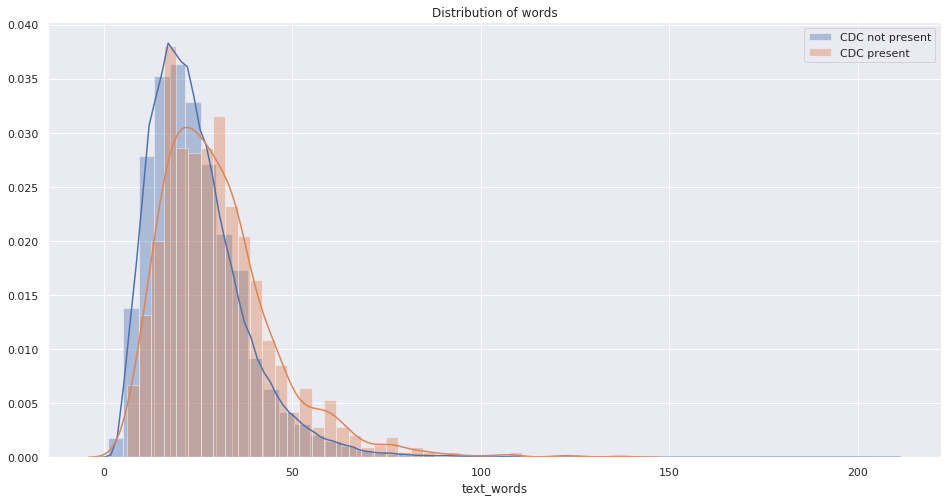

In [0]:
plt.figure(figsize=(16,8))
sns.distplot(nc['text_words'], label='CDC not present')
sns.distplot(wc['text_words'], label='CDC present')
plt.title('Distribution of words')
plt.legend()
plt.show()

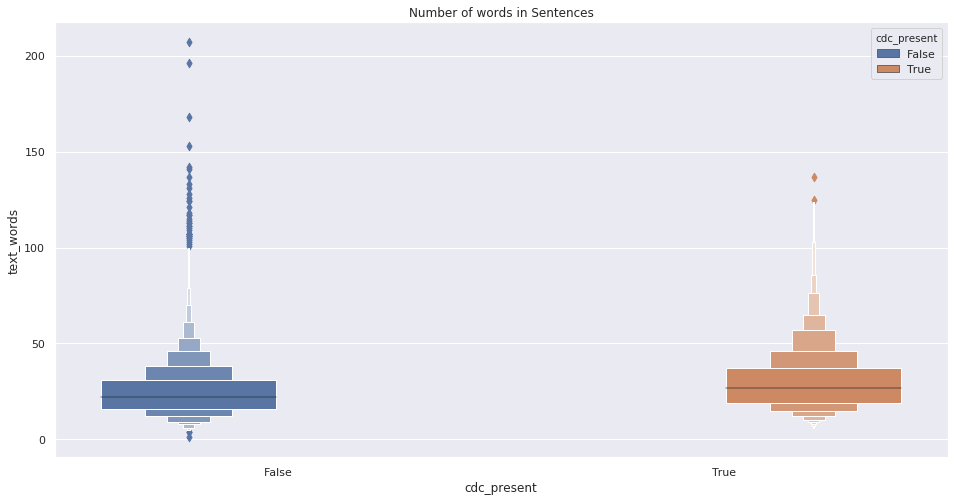

In [0]:
plt.figure(figsize=(16,8))
sns.boxenplot('cdc_present','text_words', data=df, hue='cdc_present')
plt.title('Number of words in Sentences')

plt.show()

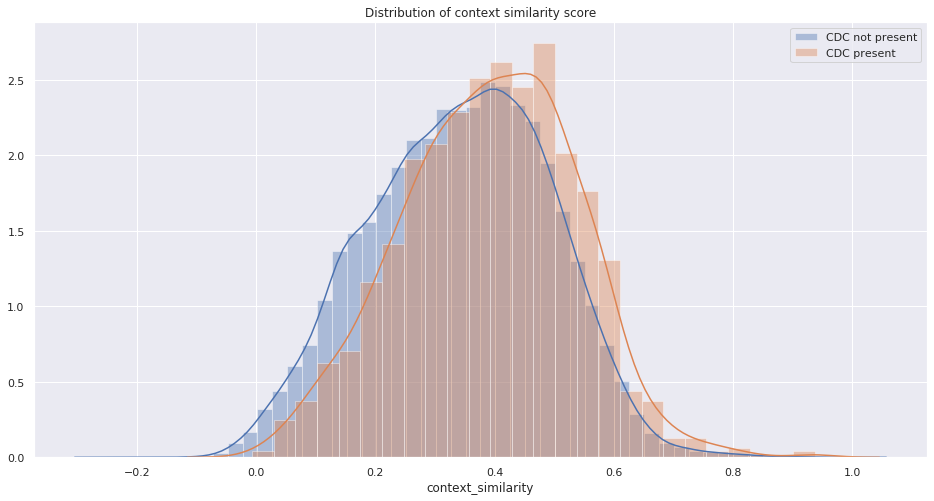

In [0]:
plt.figure(figsize=(16,8))
sns.distplot(nc['context_similarity'], label='CDC not present')
sns.distplot(wc['context_similarity'], label='CDC present')
plt.title('Distribution of context similarity score')
plt.legend()
plt.show()

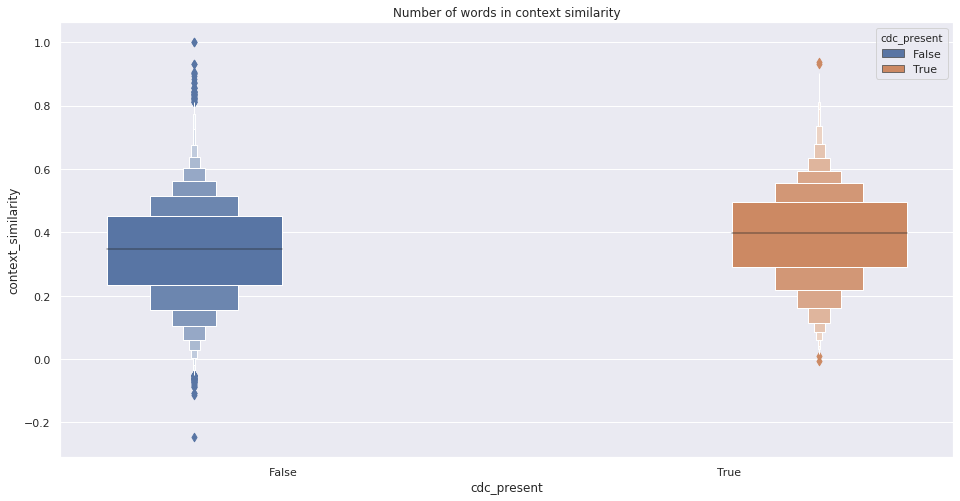

In [0]:
plt.figure(figsize=(16,8))
sns.boxenplot('cdc_present','context_similarity', data=df, hue='cdc_present')
plt.title('Number of words in context similarity')

plt.show()

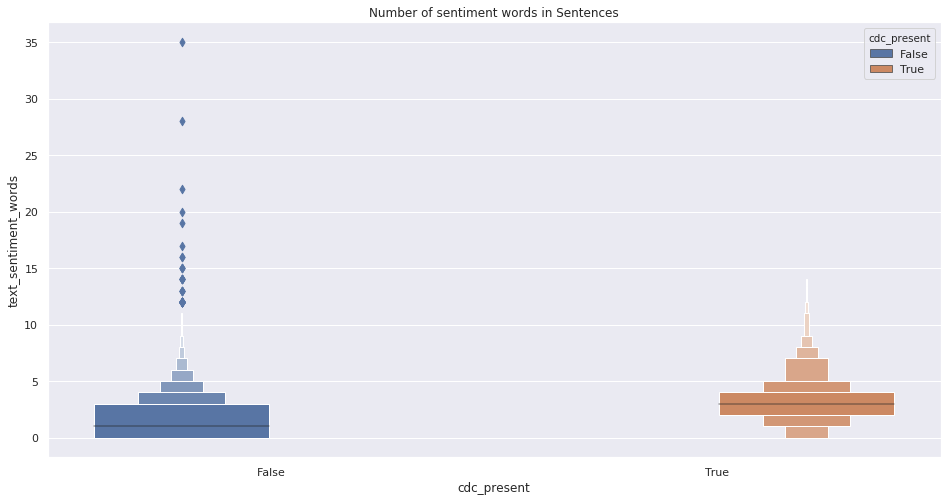

In [0]:
plt.figure(figsize=(16,8))
sns.boxenplot('cdc_present','text_sentiment_words', data=df, hue='cdc_present')
plt.title('Number of sentiment words in Sentences')

plt.show()

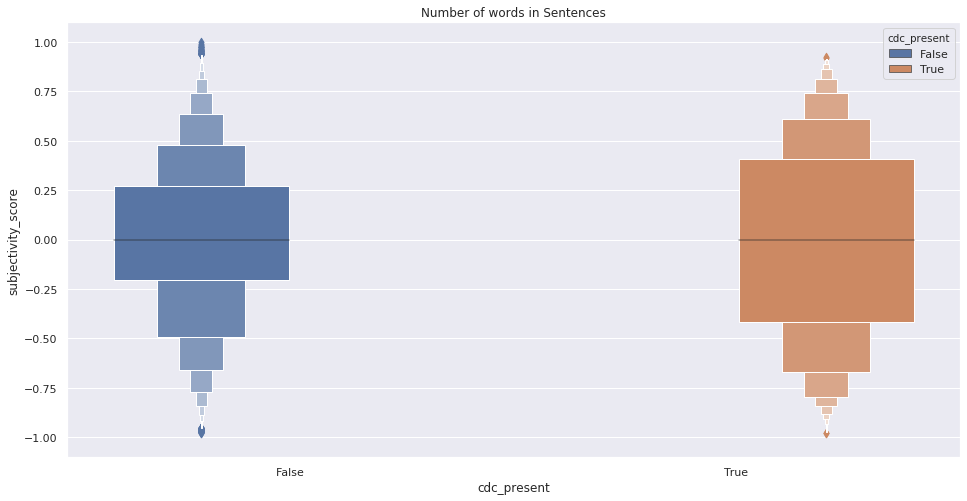

In [0]:
plt.figure(figsize=(16,8))
sns.boxenplot('cdc_present','subjectivity_score', data=df, hue='cdc_present')
plt.title('Number of words in Sentences')

plt.show()

Overall, there do not appear to be any distinguishing differences in sentence statistics.  Mean context similarity is higher when CDC's are present.  This is expected, however, the difference is small.  Perhaps the model will discover patterns that we do not easily see.

## Preprocessing

Data has cleaned and saved.  For demonstration purposes, the holdout set will be fed to trained models.  Therefore, the preprocessing step is simply loading the data and dividing features from the target.

In [0]:
test_data_1.head()

,Unnamed: 0,txt_0,txt_1,txt_2,txt_3,txt_4,txt_5,txt_6,txt_7,txt_8,txt_9,txt_10,txt_11,txt_12,txt_13,txt_14,txt_15,txt_16,txt_17,txt_18,txt_19,txt_20,txt_21,txt_22,txt_23,txt_24,txt_25,txt_26,txt_27,txt_28,txt_29,txt_30,txt_31,txt_32,txt_33,txt_34,txt_35,txt_36,txt_37,txt_38,...,cxt_270,cxt_271,cxt_272,cxt_273,cxt_274,cxt_275,cxt_276,cxt_277,cxt_278,cxt_279,cxt_280,cxt_281,cxt_282,cxt_283,cxt_284,cxt_285,cxt_286,cxt_287,cxt_288,cxt_289,cxt_290,cxt_291,cxt_292,cxt_293,cxt_294,cxt_295,cxt_296,cxt_297,cxt_298,cxt_299,0,1,2,3,4,5,6,7,8,cdc_present
0,7497,-0.130206,0.048355,-0.114702,-0.009982,-0.030156,0.150491,-0.017356,0.057735,-0.041114,2.101023,-0.043877,0.078018,0.002753,-0.052786,-0.061446,0.014759,-0.121566,0.927315,-0.286600,-0.036176,-0.000199,-0.050020,-0.160738,-0.015966,0.096847,0.067825,0.109046,0.023804,0.103921,-0.090594,-0.057840,0.114495,-0.058922,0.050211,0.089209,-0.134626,-0.097672,0.002909,-0.006185,...,-0.463380,-0.204360,0.048473,-0.205093,-0.363393,0.033035,-0.010813,-0.022343,-0.075073,0.207637,0.33706,0.113085,-0.186804,-0.026109,-0.091814,0.132277,-0.041427,-0.309250,0.321133,-0.391453,-0.356706,-0.081472,-0.350020,0.164247,0.399030,0.239813,-0.153626,-0.230494,-0.117433,0.191165,0.480536,0.891133,0.880104,-0.142830,0.363169,0.524713,-0.104423,0.095498,-0.084667,False
1,30459,-0.107958,0.130110,-0.041047,-0.073007,0.145519,0.128093,-0.051751,0.001700,-0.130625,2.022824,-0.404143,-0.150002,0.155436,-0.110040,0.010022,0.060276,0.046602,0.910897,-0.064484,-0.054252,-0.058690,0.047674,0.015414,-0.040094,-0.023689,-0.013516,0.060345,0.172027,-0.070313,0.069009,-0.022220,-0.117145,0.086945,0.037613,0.087911,-0.117652,-0.092293,-0.098157,-0.112901,...,-0.189749,-0.396070,0.030718,-0.345085,0.699060,-0.426885,-0.386480,0.660045,-0.619115,-0.019320,0.39222,0.489230,-0.066925,-0.575683,0.163460,-0.276995,0.095197,-0.210605,0.094585,-0.070190,-0.552530,-0.042400,-0.750065,-0.249599,-0.264560,0.713130,-0.149760,-0.092975,-0.285510,-0.709820,-0.210406,-0.170143,-0.417555,0.551385,-0.174515,0.004164,-0.254874,1.338301,-1.358486,False
2,25533,-0.075064,0.038415,0.027696,-0.122820,0.043874,-0.102859,-0.000766,0.090644,-0.022766,2.237026,-0.254189,0.049830,0.098319,-0.047823,-0.009108,-0.051286,0.001306,0.964063,-0.007666,-0.018539,-0.012737,-0.047673,0.059876,0.023681,-0.034380,-0.083902,-0.043754,0.013231,-0.012982,0.127392,-0.022522,0.002302,-0.102024,0.013296,0.073121,-0.092281,-0.083372,-0.057125,-0.014944,...,0.307762,-0.188501,-0.003370,0.097000,0.084940,0.021967,0.205906,0.047007,0.124798,-0.078075,0.09538,0.115032,-0.096754,0.017406,-0.040473,-0.024575,-0.118206,-0.041355,0.176702,-0.206805,-0.261248,0.135761,0.004245,-0.045272,-0.150872,-0.141105,0.085664,0.015103,-0.014373,0.120442,0.864392,0.976035,1.033141,-0.142830,1.169695,1.565809,0.077088,0.243562,0.112166,False
3,4455,-0.101454,0.003288,0.007618,-0.011705,-0.004709,-0.020165,0.025580,0.047598,-0.076953,2.289741,-0.220427,0.043469,-0.042790,-0.010778,0.005612,0.054999,-0.122046,0.794144,-0.153406,0.093457,-0.033145,-0.080009,0.140504,0.011131,0.135749,0.003123,0.033147,-0.013293,-0.095701,0.083380,0.034392,0.060056,0.046893,-0.073994,0.109000,-0.110334,-0.036644,-0.049474,-0.008827,...,0.183540,-0.294305,-0.195535,-0.088610,0.339498,0.434715,-0.214650,0.280800,0.512500,-0.113770,-0.21993,-0.529584,-0.050285,-0.094307,-0.067860,-0.233844,-0.218420,-0.088710,-0.048320,-0.172400,-0.020990,0.002080,-0.000328,-0.042084,0.419700,-0.096648,-0.187825,0.461215,0.214574,-0.054802,0.634078,0.806231,-0.652804,-0.837045,0.363169,0.351197,-1.350981,-1.241383,0.733690,False
4,26693,0.049703,0.143664,-0.180584,-0.003236,0.010516,0.031385,-0.013620,-0.098701,-0.046195,2.446345,-0.083923,0.042283,0.132431,0.016977,-0.197173,-0.091144,-0.046572,0.972449,-0.151526,-0.008244,0.043451,-0.025238,0.035713,-0.056225,-0.070203,0.003437,-0.082078,-0.078374,-0.050749,-0.061852,-0.040118,0.097999,0.001042,0.130845,0.049134,-0.132049,0.011667,-0.068457,-0.091122,...,0.307762,-0.188501

In [0]:
X = test_data_1.drop(columns=['Unnamed: 0', 'cdc_present'])
y = test_data_1['cdc_present']

## First round cuts

In [0]:
# Load pretrained model
mod_path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 34 - Final Capstone/data/CDC Detection/funnel_1_model.sav'

model_1 = pickle.load(open(mod_path, 'rb'))

In [0]:
predict = model_1.predict(X)

print("\n----------------------Model Scores----------------------")
print('Model accuracy score:', model_1.score(X, y))
print('Model precision score:', precision_score(y, predict))
print('Model recall score:', recall_score(y, predict))


----------------------Model Scores----------------------
Model accuracy score: 0.8044761904761905
Model precision score: 0.1099640933572711
Model recall score: 0.7777777777777778


In [0]:
conf_matrix(y, predict)

,Predicted_0,Predicted_1
Actual_0,8202,1983
Actual_1,70,245


Consider this pipeline as akin to professional sports teams' building a roster.   This model represents the first round of "cuts".  Out of the 10,500 sentences in this set, only 2228 candidates have been identified.  

This is a 75% reduction of noise. 

## Sentence Dissection

After the first round of cuts, the 2,228 candidate sentences move on in the pipeline to the sentence dissection step.

This part of the pipeline is primarily rule based relies on the following assumptions:

* CDCs are either simple sentences or independent clauses within complex sentences.  This means:
 * They must contain complete thoughts (have minimum elements of a simple sentence:  subject, verb, object)
 * They must be grammatically correct
* In a sentence with multiple clauses, a CDC will be the clause with the strongest "stance".
 * It will demonstrate the highest sentiment and polarity
 * Where c is the claim, t is the topic-context, R is the sentiment relationship between instances of t and c, and p is polarity, stance is calculated as follows:
 $$Stance_{(c,t)} = p_c * R(x_c, x_t) * p_t$$

Based on these assumptions, sentences and clauses failing the rule-based tests are discarded.  Functions are written to
1. Identify if elements in the clause are adequate to call it a sentence
2. Evaluate each clause with rule-based model "Language Tool" for grammatical correctness.

In [0]:
test_data_2.shape

(2171, 614)

## Preprocessing 2

This part of the funnel was able to cut 57 more candidates.  After this step, a final model will make the last of the cuts.

In [0]:
test_data_2.head(3)

,Unnamed: 0,cdc,cdc_present,context,clause,stance,words,syllables,sentiment_words,nouns,sent_rat,context_similarity,expanded_similarity,subjectivity_score,txt_0,txt_1,txt_2,txt_3,txt_4,txt_5,txt_6,txt_7,txt_8,txt_9,txt_10,txt_11,txt_12,txt_13,txt_14,txt_15,txt_16,txt_17,txt_18,txt_19,txt_20,txt_21,txt_22,txt_23,txt_24,txt_25,...,cxt_260,cxt_261,cxt_262,cxt_263,cxt_264,cxt_265,cxt_266,cxt_267,cxt_268,cxt_269,cxt_270,cxt_271,cxt_272,cxt_273,cxt_274,cxt_275,cxt_276,cxt_277,cxt_278,cxt_279,cxt_280,cxt_281,cxt_282,cxt_283,cxt_284,cxt_285,cxt_286,cxt_287,cxt_288,cxt_289,cxt_290,cxt_291,cxt_292,cxt_293,cxt_294,cxt_295,cxt_296,cxt_297,cxt_298,cxt_299
0,0,---,False,right to bear arms,restrictions on felon ownership of firearms di...,0.106768,11,18,1,4,0.090909,0.447249,0.216302,0.3875,0.080393,0.036184,-0.296513,0.030171,-0.080085,-0.056870,0.060005,-0.113893,-0.043942,2.376373,-0.208267,0.088837,0.081353,0.114954,-0.244817,-0.113150,-0.061540,0.761227,0.009723,0.075449,0.204111,-0.053163,0.186765,-0.027354,-0.088412,-0.152941,...,-0.273495,0.180730,0.142170,-0.011811,0.071116,0.069556,0.048623,-0.023608,0.148230,-0.005975,0.307762,-0.188501,-0.003370,0.097000,0.084940,0.021967,0.205906,0.047007,0.124798,-0.078075,0.09538,0.115032,-0.096754,0.017406,-0.040473,-0.024575,-0.118206,-0.041355,0.176702,-0.206805,-0.261248,0.135761,0.004245,-0.045272,-0.150872,-0.141105,0.085664,0.015103,-0.014373,0.120442
1,1,---,False,affirmative aciton,luck was too much of a variable in economics,0.111407,9,13,1,3,0.111111,0.059129,0.017785,0.4588,-0.104837,0.279544,-0.022467,-0.082514,-0.024036,0.058078,0.081180,-0.205556,-0.069566,2.242743,-0.290025,-0.005721,0.074118,0.067591,-0.096402,-0.110541,-0.111803,1.207566,-0.175685,-0.037334,-0.160528,-0.108331,-0.130913,-0.021883,0.049593,-0.155600,...,-0.899770,0.074667,0.011280,0.078425,-0.303396,0.275712,0.096043,-0.110640,0.257587,0.352364,0.183540,-0.294305,-0.195535,-0.088610,0.339498,0.434715,-0.214650,0.280800,0.512500,-0.113770,-0.21993,-0.529584,-0.050285,-0.094307,-0.067860,-0.233844,-0.218420,-0.088710,-0.048320,-0.172400,-0.020990,0.002080,-0.000328,-0.042084,0.419700,-0.096648,-0.187825,0.461215,0.214574,-0.054802
2,2,---,False,physical education,only socialization that takes place explicitly,0.000000,6,15,0,2,0.000000,0.509795,0.237417,0.0000,0.070133,0.196895,-0.089567,0.034461,-0.043734,-0.024805,-0.102026,0.091727,0.148654,2.350083,-0.006274,0.108051,-0.105276,0.094623,-0.008241,0.077131,-0.140222,0.845746,-0.177193,-0.017642,-0.139662,-0.200465,0.102861,-0.006388,0.031106,-0.017749,...,-0.127505,0.007055,0.146639,0.211151,-0.166130,-0.141890,-0.340995,-0.111145,0.516420,-0.029180,-0.606520,0.043256,-0.169571,-0.093181,-0.446615,0.180314,-0.011280,-0.088868,-0.307160,0.131710,-0.51924,-0.231505,-0.026492,0.223532,-0.201455,-0.505555,-0.102415,-0.097368,-0.099250,-0.218825,0.275148,-0.043449,-0.031048,0.148230,-0.102086,0.264600,0.103510,-0.209790,-0.153765,0.015765


In [0]:
X = test_data_2.drop(columns=['Unnamed: 0', 'cdc', 'cdc_present', 
                              'clause', 'context'])
y = test_data_2['cdc_present']

## Model

In [0]:
# Load pretrained model
mod_path = '/content/drive/My Drive/Colab Notebooks/Thinkful/Module 34 - Final Capstone/data/CDC Detection/funnel_2_model.sav'

model_2 = pickle.load(open(mod_path, 'rb'))

In [0]:
predict = model_2.predict(X)

print("\n----------------------Model Scores----------------------")
print('Model accuracy score:', model_2.score(X, y))
print('Model precision score:', precision_score(y, predict))
print('Model recall score:', recall_score(y, predict))


----------------------Model Scores----------------------
Model accuracy score: 0.63841547673883
Model precision score: 0.1588447653429603
Model recall score: 0.6055045871559633


In [0]:
conf_matrix(y, predict)

,Predicted_0,Predicted_1
Actual_0,1254,699
Actual_1,86,132


In [0]:
#Let's look at the output
test_data_2['prediction'] = predict

output = test_data_2.loc[test_data_2['prediction']==True]
output.shape

(831, 615)

In [0]:
output.reset_index(inplace=True)


In [0]:
for i,cdc in enumerate(output['clause'][:10]):
    print('Topic: ', output['context'][i])
    print('cdc_present: ', output['cdc_present'][i])
    print('predicted_cdc: ')
    print(cdc)
    print("")


Topic:  right to bear arms
cdc_present:  False
predicted_cdc: 
restrictions on felon ownership of firearms did not violate this right

Topic:  physical education
cdc_present:  False
predicted_cdc: 
only socialization that takes place explicitly

Topic:  nuclear weapons
cdc_present:  False
predicted_cdc: 
not only does Pakistan lack the same energy requirements but that the track record of Pakistan as a nuclear proliferator makes it impossible for it to have any sort of nuclear deal in the near future

Topic:  traid aid
cdc_present:  False
predicted_cdc: 
that all their efforts are coherent and have greater impact on reducing poverty

Topic:  nuclear weapons
cdc_present:  False
predicted_cdc: 
it is unlikely that Iran would flatly ignore international reactions and develop nuclear weapons anyway

Topic:  monarchy
cdc_present:  False
predicted_cdc: 
 an egalitarian movement which had contributed greatly to Parliament's cause but sought representation for ordinary citizens

Topic:  atheis

## A look at the first 10 predictions:

In the case of True positive predictions, the labeled CDC is in bold.  

There is 1 true positive:

* Only those theories which refuse to acknowledge that <strong>there is evidence even for the existence of a God</strong>

Of the nine False Positives, at least 6 clauses clearly contain context dependent claims (in bold).

* Topic: the right to bear arms
 * <strong>restrictions on felon ownership of firearms did not violate this right</strong>

* Topic: trade aid
 * that all <strong>their efforts are coherent and have greater impact on reducing poverty</strong>
* Topic: nuclear weapons
 * <strong>it is unlikely that Iran would flatly ignore international reactions and develop nuclear weapons anyway</strong>
* Topic: atheism
 * <strong>God was a necessary metaphysical assumption demanded by circumstances</strong>
* Topic: atheism
 * <strong>who take the view that theism is dangerous or destructive</strong>
* Topic: affirmative action
 * <strong>affirmative action goes beyond ensuring access</strong> and goes into the realm of preferential treatment

This may indicate the model performs better than we are currently able to measure due to potential labeling error.  While the potential for the existence of labeling error directs attention to the drawing board, this insight is very exciting.